In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
import matplotlib.pyplot as plt
from tqdm import tqdm

# Model
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import GridSearchCV, cross_val_score

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

TRAIN_SMALL_PATH = "./etc/training_small.csv"
TRAIN_LARGE_PATH = "./etc/training_large.csv"
TEST_PATH = "./etc/test.csv"
TARGET = "is_lt_18400"
PRICE = 18400
NUMERICAL_COLS = ["price", "year", "mileage"]
CATEGORICAL_COLS = ["make", "model"]
COLS = NUMERICAL_COLS + CATEGORICAL_COLS

PARAMS = {
    "n_neighbors": np.arange(3, 25, 2),
    "leaf_size": np.arange(5, 100, 5),
    # "weights": ["uniform"],
    # "algorithm": ["auto"],
    # "p": [1],
    # "n_jobs": [-1]
}

In [15]:
def label_encode(dataFrame, cols) -> pd.DataFrame:
    les = {}
    for i, col in enumerate(cols):
        le = LabelEncoder()
        dataFrame[col] = le.fit_transform(dataFrame[col])
        les[col] = le
    return les

def preprocess(df: pd.DataFrame):    
    # Create a copy of the DataFrame
    X = df.copy()

    # Select only a few columns
    X = X[COLS]
    
    # Get the target
    y = X["price"].apply(lambda x: int(x < PRICE))

    # Drop the "price" column because we don't need it anymore
    X.drop("price", axis=1, inplace=True)
    
    # Transformers: I use different transformers for numerical and categorical columns.
    numerical_transformer = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline([
        # ('encoder', LabelEncoder()),
        ('imputer', SimpleImputer(strategy='median'))
    ])
    
    les = label_encode(X, CATEGORICAL_COLS)
    
    # Define a simplified ColumnTransformer with a single transformer
    # The steps of this pipeline are as follows:
    # 1. Scaling: Scales values according to the N(0, 1) distribution
    # 2. Impute: Deals with NaNs by imputing them with the mean
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_COLS[1:]), # Don't include "price"
            ('cat', categorical_transformer, CATEGORICAL_COLS)
        ])
    
    # Create a pipeline
    pipe = Pipeline([('preprocessor', preprocessor)])

     # And fit it
    X = pd.DataFrame(pipe.fit_transform(X), columns=X.columns)
    
    # Convert the labels to integers
    for col in CATEGORICAL_COLS:
            X[col] = X[col].apply(lambda x: int(x))
    
    return X, y, les

def preprocess_testing(df: pd.DataFrame, les):
    global COLS
    
    # Create a copy of the DataFrame
    X = df.copy()
    # print(COLS)

    # Select only a few columns
    X = X[COLS[1:]]
    
    # print(COLS, X.columns)
    
    # Use the original LabelEncoders to encode
    for col in CATEGORICAL_COLS:
        X[col] = les[col].fit_transform(X[col])
    
    # Transformers: I use different transformers for numerical and categorical columns.
    numerical_transformer = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])

    # Define a simplified ColumnTransformer with a single transformer
    # The steps of this pipeline are as follows:
    # 1. Scaling: Scales values according to the N(0, 1) distribution
    # 2. Impute: Deals with NaNs by imputing them with the mean
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_COLS[1:]), # Don't include "price"
            ('cat', categorical_transformer, CATEGORICAL_COLS)
        ])
    
    # Create a pipeline
    pipe = Pipeline([('preprocessor', preprocessor)])

     # And fit it
    X = pd.DataFrame(pipe.fit_transform(X), columns=X.columns)
    
    # Convert the labels to integers
    for col in CATEGORICAL_COLS:
            X[col] = X[col].apply(lambda x: int(x))
    
    return X

def train_and_evaluate(model, X_train, y_train, X_test, y_test, params=None):
    if (not params):
        params = PARAMS

    # Use GridSearchCV with the maximum number of CPU cores available
    grid_search = GridSearchCV(model, params, cv=5, scoring="f1_micro", n_jobs=-1)

    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best estimator after grid search
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate
    print("sum(y_pred == y_test): ", sum(y_pred == y_test))
    print("len(y_test): ", len(y_test))
    
    pct = sum(y_pred == y_test) / len(y_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.savefig("cm.png")

    # Get cross-validation scores from GridSearchCV results
    cv_scores = grid_search.cv_results_['mean_test_score']
    
    return {
        'gcv': grid_search,
        'cv_scores': cv_scores,
        'pct': pct,
        'y_pred': y_pred,
        'model': best_model
    }

def f(i, X_train, y_train, X_test, y_test):
    '''Master method to train and evaluate models, display the results and plot graphs.'''
    results = train_and_evaluate(KNC(), X_train, y_train, X_test, y_test)

    # Extract the results
    cv_scores = results['cv_scores']
    pct = results['pct']
    y_pred = results['y_pred']
    best_model = results['model']

    # Print or use the extracted results as needed
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Percentage correct: {pct}')
    print(f'Best Model: {best_model}')
    
    model_name = f"knn{i}"
    
    # Save the model
    print(f"Saving model {i}...")
    dump(best_model, filename=model_name)
    print("Saved.")
    
    return results

def get_test_preds(model, les, large: bool = False):
    # Load test data
    test = pd.read_csv(TEST_PATH)
    
    # Preprocess test data
    test_preprocessed = preprocess_testing(test, les)
    
    print(test_preprocessed.head())
    
    print("preds:")
    
    # Get predictions
    preds = model.predict(test_preprocessed)
    df = pd.DataFrame(preds)
    print(df.head())
    print(df.value_counts())
    
    d = "small"
    if (large):
        d = "large"

    # And save them
    filename = f"test_preds_{d}.csv"
    np.savetxt(filename, preds.astype(int), delimiter=",", header=TARGET)

    # Sanity check
    d = pd.read_csv(filename)
    print(d.shape)
    print(d.head())

def master(large: bool = False):
    '''Master method to do everything.'''
    dataset = TRAIN_SMALL_PATH
    if (large):
        dataset = TRAIN_LARGE_PATH
    
    print("Dataset: ", dataset)
    train = pd.read_csv(dataset)
        
    print("train.tail():")
    print(train.tail())
    
    print("------------------------------------")
    
    X, y, les = preprocess(train)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
    print("X_train.tail():")
    print(X_train.tail())
    
    print("------------------------------------")
    print("Training...")
    
    results = train_and_evaluate(KNC(n_jobs=-1, weights="uniform", p=1, algorithm="auto"), X_train, y_train, X_test, y_test)
    
    i = 2 + int(large)

    # Extract the results
    cv_scores = results['cv_scores']
    pct = results['pct']
    y_pred = results['y_pred']
    best_model = results['model']

    # Print or use the extracted results as needed
    # print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Percentage correct: {pct}')
    print(f'Best Model: {best_model}')
    
    model_name = f"knn{i}"
    
    # Save the model
    print(f"Saving model {i}...")
    dump(best_model, filename=model_name)
    print("Saved.")
    
    print("------------------------------------")
    print("Testing...")
    get_test_preds(best_model, les, large)
    
    return results

Dataset:  ./etc/training_small.csv
train.tail():
       price  year  mileage          city state       make          model
99995   9900  2003   148000      Avondale    AZ  Chevrolet  Avalanche1500
99996  17482  2016    22084      Lakewood    NJ  Chevrolet        TraxAWD
99997  28500  2014    35134     Hemingway    SC       Ford       F-1504WD
99998  26800  2015    40268  Merrillville    IN     Subaru   Forester2.5i
99999  46787  2012    46416      Bellevue    WA        Ram        25004WD
------------------------------------
X_train.tail():
           year   mileage  make  model
35619  0.857143  0.011332    17   1625
54303  0.809524  0.029566     9    356
97053  0.714286  0.032571    10   1773
56437  0.809524  0.055973    17   1625
60856  0.619048  0.081682     1   1708
------------------------------------
Training...
sum(y_pred == y_test):  27421
len(y_test):  30000
Percentage correct: 0.9140333333333334
Best Model: KNeighborsClassifier(leaf_size=10, n_jobs=-1, n_neighbors=7, p=1)
Savi

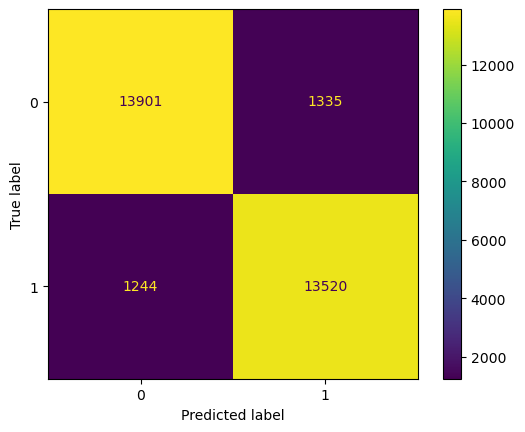

In [16]:
small = master(False)

In [17]:
small['gcv'].best_params_

{'leaf_size': 10, 'n_neighbors': 7}

Dataset:  ./etc/training_large.csv
train.tail():
        price  year  mileage          city state       make       model
499995  13812  2013    43548     San Diego    CA       Ford    EscapeSE
499996  36987  2017     8604    Washington    NC     Toyota   Tacoma4WD
499997  15595  2014    61368    Sacramento    CA        Kia  SportageLX
499998   3995  2005   181600         Butte    MT       Ford    Explorer
499999  39495  2015    26480  Higginsville    MO  Chevrolet   Silverado
------------------------------------
X_train.tail():
            year   mileage  make  model
428835  0.761905  0.013395     5   2367
54303   0.809524  0.017671     9    470
490269  0.809524  0.013128    15    359
187509  0.809524  0.012280     5     91
323000  0.666667  0.026406    15    963
------------------------------------
Training...
sum(y_pred == y_test):  138600
len(y_test):  150000
Percentage correct: 0.924
Best Model: KNeighborsClassifier(leaf_size=70, n_jobs=-1, n_neighbors=11, p=1)
Saving model 3...
Sa

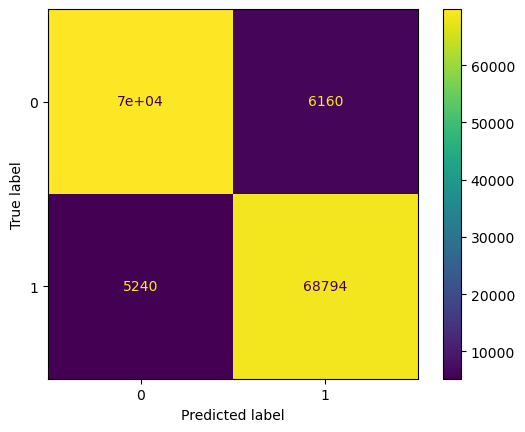

In [18]:
large = master(True)

In [6]:
large['gcv'].best_params_

{'leaf_size': 70, 'n_neighbors': 11}

Dataset:  ./etc/training_small.csv


100%|██████████| 100/100 [06:31<00:00,  3.91s/it]


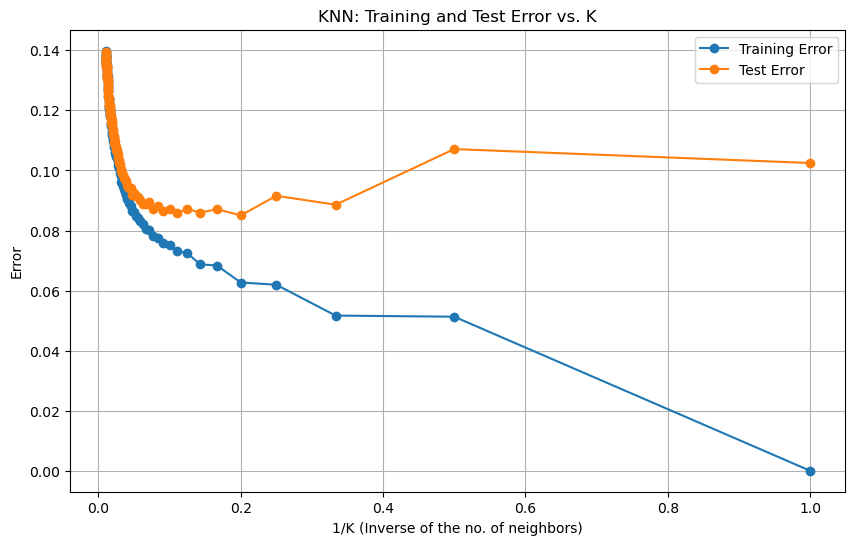

In [7]:
%matplotlib inline
def plot_q2(large: bool = False):
    d = "small"
    dataset = TRAIN_SMALL_PATH
    if (large):
        d = "large"
        dataset = TRAIN_LARGE_PATH
    
    print("Dataset: ", dataset)
    train = pd.read_csv(dataset)    
    X, y, les = preprocess(train)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
    
    # Lists to store errors
    training_error = []
    test_error = []

    # Range of K values
    K_values = np.arange(100, 0, -1)

    # Loop over various K values
    for K in tqdm(K_values):
        # Initialize and train KNN classifier
        knn = KNC(n_neighbors=K, p=1, algorithm="auto", weights="uniform", n_jobs=-1)
        knn.fit(X_train, y_train)

        # Predict on training and test data
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)

        # Calculate errors and append to lists
        training_error.append(1 - accuracy_score(y_train, y_train_pred))
        test_error.append(1 - accuracy_score(y_test, y_test_pred))

    # Plotting
    inverse = [1/val for val in K_values]
    plt.figure(figsize=(10, 6))
    plt.plot(inverse, training_error, marker='o', label='Training Error')
    plt.plot(inverse, test_error, marker='o', label='Test Error')
    plt.xlabel('1/K (Inverse of the no. of neighbors)')
    plt.ylabel('Error')
    plt.title('KNN: Training and Test Error vs. K')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"q2_{d}.png")
    plt.show()
    

plot_q2(False)

Dataset:  ./etc/training_large.csv


100%|██████████| 100/100 [50:56<00:00, 30.57s/it]


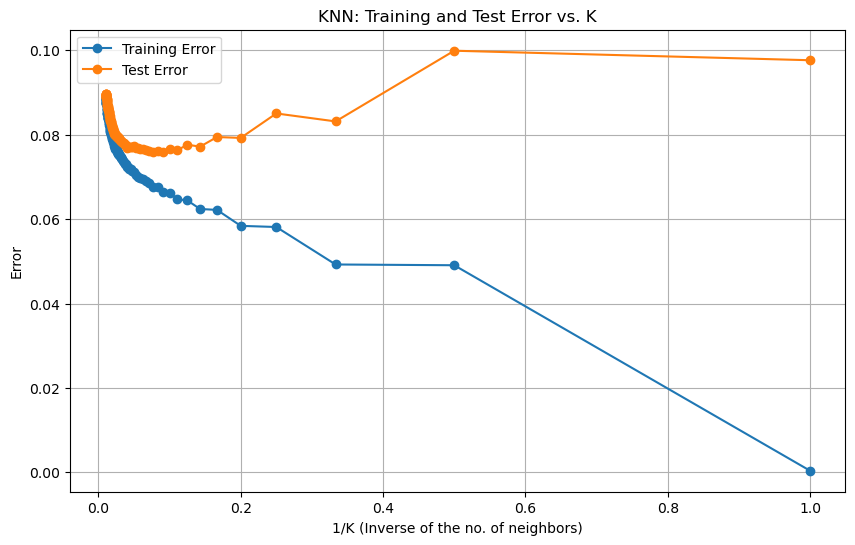

In [19]:
plot_q2(True)

Dataset:  ./etc/training_small.csv


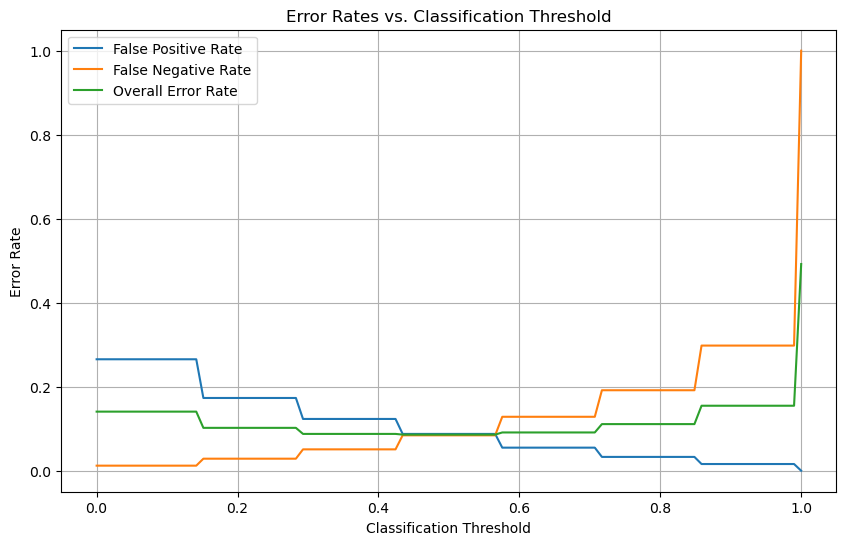

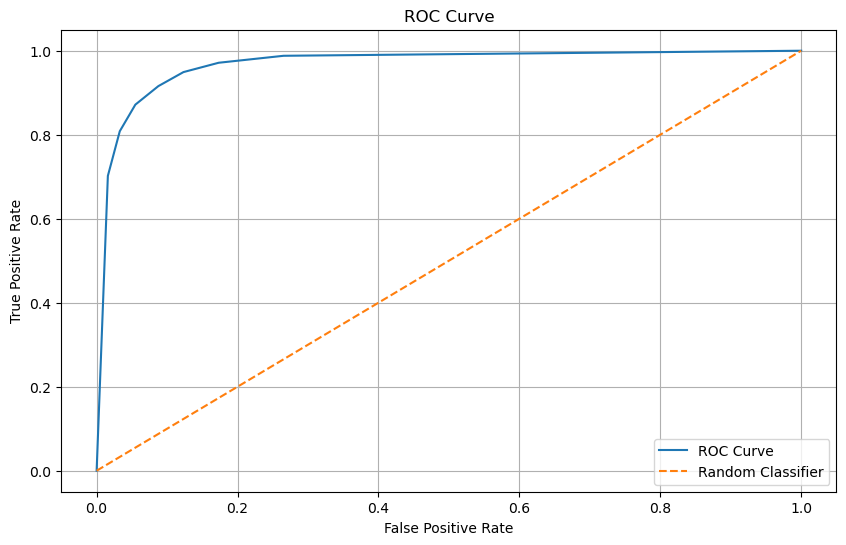

In [8]:
%matplotlib inline
def plot_q3(large: bool=False):
    d = "small"
    dataset = TRAIN_SMALL_PATH
    if (large):
        d = "large"
        dataset = TRAIN_LARGE_PATH
    
    print("Dataset: ", dataset)
    train = pd.read_csv(dataset)    
    X, y, les = preprocess(train)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
    
    # Initialize and train KNN classifier
    knn = KNC(n_neighbors=7, p=1, algorithm="auto", weights="uniform", n_jobs=-1)
    knn.fit(X_train, y_train)

    # Get the probability of y=1
    y_prob = knn.predict_proba(X_test)[:, 1]

    # Lists to store false positive and true positive rates
    fpr_list = []
    tpr_list = []
    accuracy_list = []

    # Range of threshold values
    thresholds = np.linspace(0, 1, 100)

    # Loop over threshold values
    for thresh in thresholds:
        # Get binary predictions
        y_pred = (y_prob > thresh).astype(int)

        # Get false positive and true positive rates
        fp = np.sum((y_pred == 1) & (y_test == 0))
        tp = np.sum((y_pred == 1) & (y_test == 1))
        fn = np.sum((y_pred == 0) & (y_test == 1))
        tn = np.sum((y_pred == 0) & (y_test == 0))

        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)

        # Get accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Append to lists
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        accuracy_list.append(accuracy)

    # Plotting error rates and accuracy vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fpr_list, label='False Positive Rate')
    plt.plot(thresholds, [1-t for t in tpr_list], label='False Negative Rate')
    plt.plot(thresholds, [1-a for a in accuracy_list], label='Overall Error Rate')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Error Rate')
    plt.title('Error Rates vs. Classification Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"q3_1_{d}.png")
    plt.show()

    # Plotting ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"q3_2_{d}.png")
    plt.show()

plot_q3(False)

Dataset:  ./etc/training_large.csv


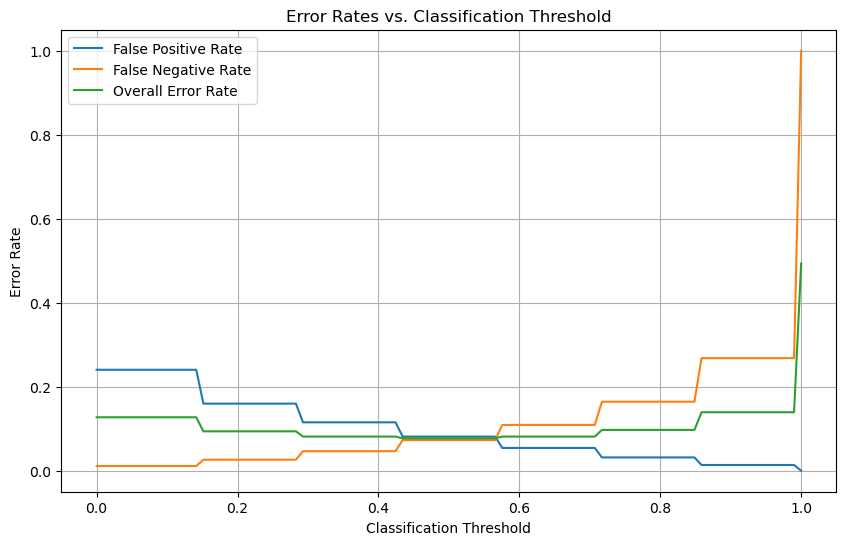

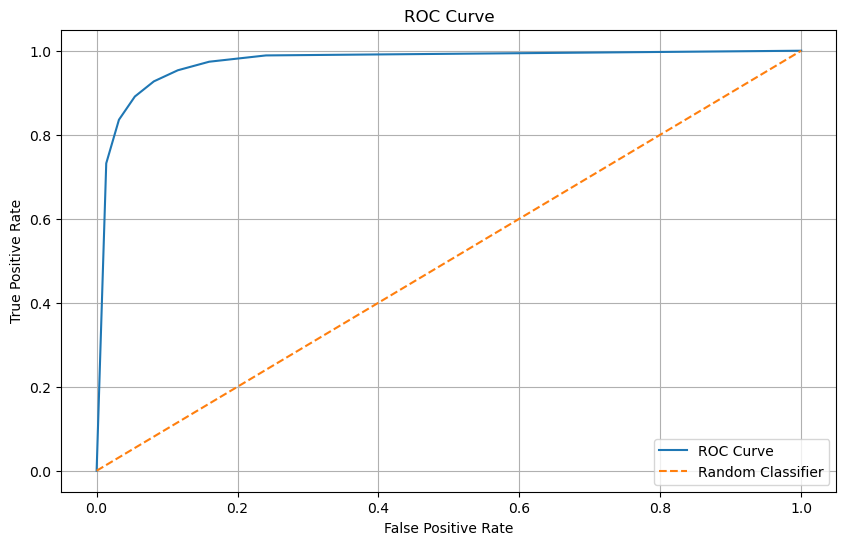

In [9]:
plot_q3(True)